In [41]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import os
import cv2

In [42]:
# 1. Veri Seti Yolu
data_path = "Kedi Köpek Data Yolu"  

# 2. Veri Önişleme Transformasyonu
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Görüntüleri gri tonlamaya çevir
    transforms.Resize((128, 128)),  # Görüntüleri 128x128 boyutuna yeniden boyutlandır
    transforms.ToTensor(),  # Görüntüleri tensor formatına dönüştür
    transforms.Normalize((0.5,), (0.5,))  # Normalizasyon: Ortalama 0.5, standart sapma 0.5
])

# 3. Veri Kümesini Yükleme
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# 4. Eğitim ve Test Seti Ayırma
train_size = int(0.8 * len(dataset)) # Eğitim seti boyutunu belirle (%80)
test_size = len(dataset) - train_size # Test seti boyutunu belirle (%20)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # Eğitim ve Test olarak veri setini ayır.

# 5. Veri Yükleyiciler
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Eğitim verileri için yükleyici
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Test verileri için yükleyici

print(f"Toplam Görüntü Sayısı: {len(dataset)}")
print(f"Eğitim Seti: {len(train_dataset)}, Test Seti: {len(test_dataset)}")

Toplam Görüntü Sayısı: 1000
Eğitim Seti: 800, Test Seti: 200


In [43]:
# 1. Veri Yükleme ve Transform
data_path = "Kedi Köpek Data Yolu"  

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Görüntüleri gri tonlamaya çevir
    transforms.Resize((128, 128)),               # Görüntüleri 128x128 boyutuna yeniden boyutlandır
    transforms.ToTensor(),                       # Görüntüleri tensor formatına dönüştür
    transforms.Normalize((0.5,), (0.5,))         # Normalizasyon: Ortalama 0.5, standart sapma 0.5
])

dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))    # Eğitim seti boyutunu belirle (%80)
test_size = len(dataset) - train_size   # Test seti boyutunu belirle (%20)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size]) # Eğitim ve Test olarak veri setini ayır.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)    # Eğitim verileri için yükleyici
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)     # Test verileri için yükleyici

# 2. ANN Modeli Tanımlama
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()    
        self.flatten = nn.Flatten()            # Giriş görüntüsünü düzleştir
        self.fc1 = nn.Linear(128 * 128, 512)   # Giriş katmanı: 128x128 boyutunu 512'ye indir
        self.fc2 = nn.Linear(512, 128)         # Gizli katman: 512'den 128'e indir
        self.fc3 = nn.Linear(128, 2)           # Çıkış katmanı: 2 sınıf (kedi/köpek)

    def forward(self, x):
        x = self.flatten(x)           # Görüntüyü düzleştir
        x = torch.relu(self.fc1(x))   # İlk katmana ReLU aktivasyonu uygula
        x = torch.relu(self.fc2(x))   # İkinci katmana ReLU aktivasyonu uygula
        x = self.fc3(x)               # Çıkış katmanını hesapla
        return x

# 3. Model, Loss ve Optimizer
model_ann = ANN()                  # Modeli tanımla
criterion = nn.CrossEntropyLoss()  # Kayıp fonksiyonu: Çapraz Entropi
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)   # Optimizasyon için Adam algoritması

# 4. Model Eğitimi
def train(model, loader, criterion, optimizer, epochs=25):
    model.train()                  # Modeli eğitim moduna geçir
    for epoch in range(epochs):
        total_loss = 0   # Toplam kaybı sıfırla
        for images, labels in loader:   # Eğitim verilerinde iterasyon yap
            optimizer.zero_grad()        # Optimizasyonun gradyanlarını sıfırla 
            outputs = model(images)       # Modelin tahminlerini al
            loss = criterion(outputs, labels)   # Kayıp değerini hesapla
            loss.backward()   # Geri yayılım ile gradyanları hesapla
            optimizer.step()   # Optimizasyonu güncelle
            total_loss += loss.item()   # Toplam kayba ekle 
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(loader):.4f}")   # Epoch kaybını yazdır

train(model_ann, train_loader, criterion, optimizer)  # Modeli eğit

# 5. Model Değerlendirme
def evaluate(model, loader):
    model.eval()  # Modeli değerlendirme moduna geçir
    correct = 0  # Doğru tahmin sayısını sıfırla
    total = 0  # Toplam veri sayısını sıfırla
    with torch.no_grad():  # Değerlendirme sırasında gradyan hesaplamayı devre dışı bırak
        for images, labels in loader:  # Test verilerinde iterasyon yap
            outputs = model(images)  # Modelin tahminlerini al
            _, predicted = torch.max(outputs, 1)  # Maksimum tahmin değerini ve sınıfını al
            total += labels.size(0)  # Toplam veri sayısını güncelle
            correct += (predicted == labels).sum().item()  # Doğru tahmin sayısını güncelle
    print(f"Accuracy: {100 * correct / total:.2f}%")  # Doğruluk oranını yazdır

evaluate(model_ann, test_loader)  # Modeli değerlendir

Epoch [1/25], Loss: 0.9119
Epoch [2/25], Loss: 0.6528
Epoch [3/25], Loss: 0.5270
Epoch [4/25], Loss: 0.4568
Epoch [5/25], Loss: 0.3217
Epoch [6/25], Loss: 0.2376
Epoch [7/25], Loss: 0.1630
Epoch [8/25], Loss: 0.1749
Epoch [9/25], Loss: 0.1352
Epoch [10/25], Loss: 0.1585
Epoch [11/25], Loss: 0.1485
Epoch [12/25], Loss: 0.1343
Epoch [13/25], Loss: 0.0421
Epoch [14/25], Loss: 0.0154
Epoch [15/25], Loss: 0.0061
Epoch [16/25], Loss: 0.0031
Epoch [17/25], Loss: 0.0022
Epoch [18/25], Loss: 0.0018
Epoch [19/25], Loss: 0.0015
Epoch [20/25], Loss: 0.0013
Epoch [21/25], Loss: 0.0011
Epoch [22/25], Loss: 0.0010
Epoch [23/25], Loss: 0.0009
Epoch [24/25], Loss: 0.0008
Epoch [25/25], Loss: 0.0007
Accuracy: 53.50%


In [44]:
# 1. CNN Modeli Tanımlama
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Evrişim Katmanları
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 1 giriş kanalı (gri ton), 16 filtre
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling, boyutları yarıya indirir
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 16 giriş kanalı, 32 filtre
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32 giriş kanalı, 64 filtre
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 64 giriş kanalı, 128 filtre

        # Fully Connected Katmanlar
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Fully connected katman: 128x8x8'lik özellik haritasını 256'ya indir
        self.fc2 = nn.Linear(256, 128)  # Fully connected katman: 256'dan 128'e indir
        self.fc3 = nn.Linear(128, 2)  # Çıkış katmanı: 2 sınıf (kedi/köpek)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # İlk convolution katmanına ReLU ve pooling uygula
        x = self.pool(torch.relu(self.conv2(x)))  # İkinci convolution katmanına ReLU ve pooling uygula
        x = self.pool(torch.relu(self.conv3(x)))  # Üçüncü convolution katmanına ReLU ve pooling uygula
        x = self.pool(torch.relu(self.conv4(x)))  # Dördüncü convolution katmanına ReLU ve pooling uygula
        
        # Havuzlamadan sonra tensorun şekli (batch_size, 128, 8, 8) olmalı
        x = x.view(-1, 128 * 8 * 8)  # Tensoru düzleştir (flatten)
        x = torch.relu(self.fc1(x))  # İlk fully connected katmana ReLU uygula
        x = torch.relu(self.fc2(x))  # İkinci fully connected katmana ReLU uygula
        x = self.fc3(x)  # Çıkış katmanını hesapla
        return x

# 2. Model, Loss ve Optimizer
model_cnn = CNN()  # CNN modelini tanımla
criterion = nn.CrossEntropyLoss()  # Kayıp fonksiyonu: Çapraz Entropi
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Optimizasyon için Adam algoritması

# 3. Model Eğitimi
train(model_cnn, train_loader, criterion, optimizer)  # Modeli eğit

# 4. Model Değerlendirme
evaluate(model_cnn, test_loader)  # Modeli değerlendir


Epoch [1/25], Loss: 0.6900
Epoch [2/25], Loss: 0.6779
Epoch [3/25], Loss: 0.6686
Epoch [4/25], Loss: 0.6365
Epoch [5/25], Loss: 0.5828
Epoch [6/25], Loss: 0.5389
Epoch [7/25], Loss: 0.4604
Epoch [8/25], Loss: 0.3673
Epoch [9/25], Loss: 0.2861
Epoch [10/25], Loss: 0.2060
Epoch [11/25], Loss: 0.2022
Epoch [12/25], Loss: 0.1230
Epoch [13/25], Loss: 0.0437
Epoch [14/25], Loss: 0.0340
Epoch [15/25], Loss: 0.0615
Epoch [16/25], Loss: 0.0326
Epoch [17/25], Loss: 0.0248
Epoch [18/25], Loss: 0.0326
Epoch [19/25], Loss: 0.0227
Epoch [20/25], Loss: 0.0224
Epoch [21/25], Loss: 0.0223
Epoch [22/25], Loss: 0.0208
Epoch [23/25], Loss: 0.0252
Epoch [24/25], Loss: 0.0334
Epoch [25/25], Loss: 0.0435
Accuracy: 64.00%


In [45]:
def evaluate_with_metrics(model, loader):
    model.eval()  # Modeli değerlendirme moduna geçir
    y_true = []  # Gerçek etiketleri saklamak için liste
    y_pred = []  # Tahmin edilen etiketleri saklamak için liste
    
    with torch.no_grad():  # Gradyan hesaplamayı devre dışı bırak
        for images, labels in loader:  # Test verileri üzerinde iterasyon yap
            outputs = model(images)  # Modelin tahminlerini al
            _, predicted = torch.max(outputs, 1)  # Maksimum değeri ve sınıfını al
            y_true.extend(labels.numpy())  # Gerçek etiketleri listeye ekle
            y_pred.extend(predicted.numpy())  # Tahmin edilen etiketleri listeye ekle
    
    # Metrikleri hesapla ve yazdır
    print("Classification Report:")  
    print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"], zero_division=1))  # Sınıflandırma raporu
    accuracy = accuracy_score(y_true, y_pred)  # Doğruluk oranını hesapla
    print(f"Accuracy: {accuracy:.2f}")  

print("=== ANN Model Performance ===")  
evaluate_with_metrics(model_ann, test_loader)  # ANN modelini değerlendir

print("=== CNN Model Performance ===")
evaluate_with_metrics(model_cnn, test_loader)  # CNN modelini değerlendir

=== ANN Model Performance ===
Classification Report:
              precision    recall  f1-score   support

         Cat       0.54      0.60      0.57       101
         Dog       0.53      0.46      0.50        99

    accuracy                           0.54       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.54      0.53       200

Accuracy: 0.54
=== CNN Model Performance ===
Classification Report:
              precision    recall  f1-score   support

         Cat       0.64      0.64      0.64       101
         Dog       0.64      0.64      0.64        99

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200

Accuracy: 0.64


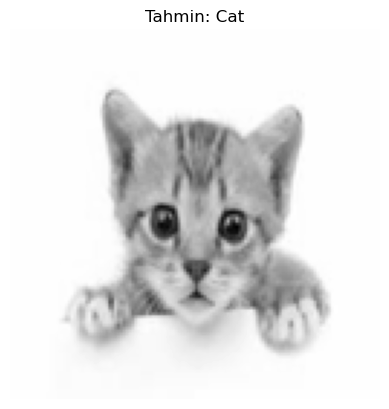

In [46]:
# Test görüntüsünün yolu
test_image_path = " Yüklediğim kedi png'sini indirin (kedi.png)"

# 1. Görüntüyü Yükleme ve Önişleme
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')  # Görüntüyü gri tona çevir
    image = image.resize((128, 128))  # Görüntüyü 128x128 boyutuna yeniden boyutlandır
    image_tensor = transforms.ToTensor()(image).unsqueeze(0)  # Tensöre dönüştür ve batch boyutunu ekle
    return image, image_tensor

# Görüntüyü yükle ve önişle
raw_image, processed_image = preprocess_image(test_image_path)

# 2. Model ile Tahmin Yapma
model_cnn.eval()  # Modeli değerlendirme 
with torch.no_grad():  # Gradyan hesaplamayı devre dışı bırak
    output = model_cnn(processed_image)  # Modelden tahmin çıktısı al
    _, predicted_class = torch.max(output, 1)  # En yüksek olasılıklı sınıfı al

# 3. Sınıf İsimlerini Elde Etme
class_names = ["Cat", "Dog"]  
predicted_label = class_names[predicted_class.item()]  # Tahmin edilen sınıf etiketini al

# 4. Görüntüyü ve Tahmini Gösterme
plt.imshow(raw_image, cmap="gray")  # Görüntüyü gri tonlamada göster
plt.title(f"Tahmin: {predicted_label}") 
plt.axis("off")  # Eksenleri gizle
plt.show()  # Görüntüyü göster